# Capacity allocation

In [2]:
!python3 -m pip install -e /home/oreto2024/PycharmProjects/robin

Obtaining file:///home/oreto2024/PycharmProjects/robin
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for robin (pyproject.toml) ... done
  Created wheel for robin: filename=robin-0.0.post1.dev693+g09e8b4e-0.editable-py3-none-any.whl size=4671 sha256=a712e887bbdff0e7e9c63789f3f917da7d67d158678c4afc64ae2f88bccc53f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-4075o6oz/wheels/c6/48/3a/80585332bc876223c19a86be895920efe423de99b02bf42862
Successfully built robin


## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from benchmarks.generator import get_revenue_behavior, get_revenue_behavior_deprecated
from benchmarks.robin_railway import RevenueMaximization
from benchmarks.utils import sns_box_plot, sns_line_plot, int_input, get_schedule_from_supply, infer_line_stations, get_services_by_tsp_df, plot_marey_chart
from src.entities import GSA, Solution
from src.timetabling_problem import MPTT

from robin.scraping.entities import SupplySaver
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Service, Supply

from mealpy.evolutionary_based import GA
from mealpy import IntegerVar
from pathlib import Path
import shutil
from typing import Any, List, Mapping, Tuple, Union

In [2]:
# Config files
supply_config_path = Path("../configs/generator/supply_config.yml")
demand_config_path = Path("../configs/demand/demand.yml")
generator_config_path = Path("../configs/generator/generator_config.yml")

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
frame_capacity = {'1': 0.3, '2': 0.25, '3': 0.2, '4': 0.15, '5': 0.1}

n_services = 50
n_services_by_ru = {ru: round(cap * n_services) for ru, cap in frame_capacity.items()}

n_services_by_ru

{'1': 15, '2': 12, '3': 10, '4': 8, '5': 5}

In [4]:
seed = 21

if generator_config_path:
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(file_name=generator_save_path,
                           path_config=generator_config_path,
                           n_services_by_ru=n_services_by_ru,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 50


In [5]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)
print(tsp_df)

     Number of Services
RU1                  15
RU2                  12
RU3                  10
RU4                   8
RU5                   5


In [6]:
print("Services: ", len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = supply.lines
line = infer_line_stations(lines)

Services:  50


In [7]:
n_services = sum(tsp_df["Number of Services"].values)

services_by_ru = {}
for service in revenue_behavior:
    if revenue_behavior[service]['ru'] not in services_by_ru:
        services_by_ru[revenue_behavior[service]['ru']] = 1
    else:
        services_by_ru[revenue_behavior[service]['ru']] += 1

services_by_ru = {f"RU{k}": v for k, v in services_by_ru.items()}
print(services_by_ru)

frame_capacity = {ru: round(services_by_ru[ru] / n_services * 100, 2) for ru in services_by_ru}
print(frame_capacity)

{'RU1': 15, 'RU2': 12, 'RU3': 10, 'RU4': 8, 'RU5': 5}
{'RU1': 30.0, 'RU2': 24.0, 'RU3': 20.0, 'RU4': 16.0, 'RU5': 10.0}


C:\Users\hyper\PycharmProjects\GSA_M\.venv\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


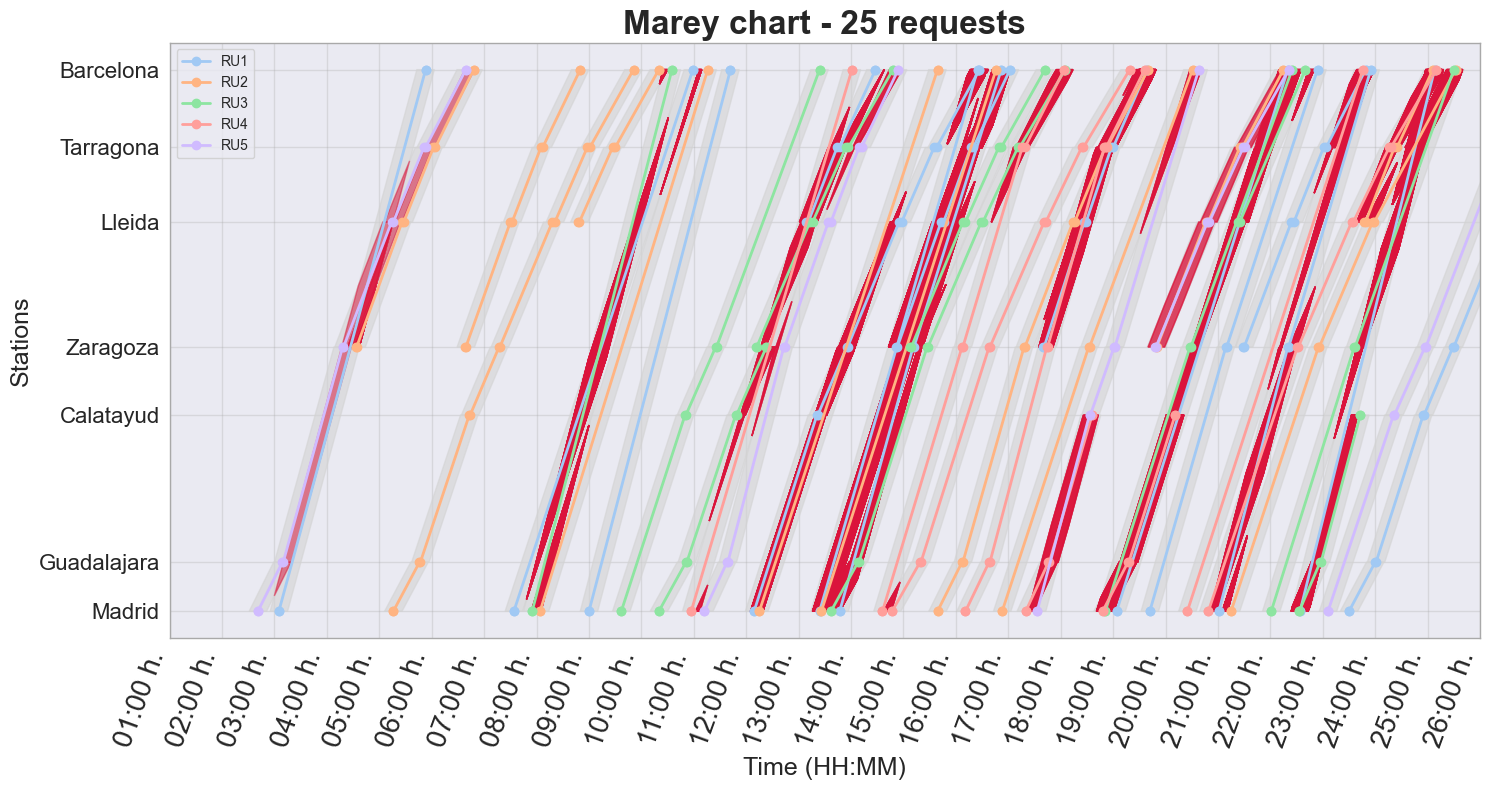

In [8]:
plot_marey_chart(requested_supply=supply,
                 colors_by_tsp=True, 
                 main_title="Marey chart - 25 requests",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_requests_25_semi_balanced.pdf'))

## 1. Mealpy

In [11]:
# ------------------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------------------

runs = 5
epochs = 100
pop_size = 50
seed_initializer = 29
fair_indices = ["Revenue", "Jain", "Gini", "Atkinson"]

# ------------------------------------------------------------------------------
# Data Collection Containers
# ------------------------------------------------------------------------------
# Lists to accumulate history and population data from each run.
history_data = []
population_data = []
population_real = [f'real_{i}' for i in range(pop_size)]
population_discrete = [f'discrete_{i}' for i in range(pop_size)]
population_columns = ['Run', 'FairIndex', 'Iteration'] + population_real + population_discrete

# ------------------------------------------------------------------------------
# 1. Iterate over Algorithms and Runs
# ------------------------------------------------------------------------------
for fair_index in fair_indices:
    # Reset random seed for reproducibility per algorithm
    np.random.seed(seed_initializer)
    print(f"Running {fair_index}")

    alpha = 25 if fair_index in ["Jain", "Atkinson"] else 10
    mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index=fair_index,
                alpha=alpha)

    # ------------------------------------------------------------------------------
    # 0. Problem Formulation
    # ------------------------------------------------------------------------------
    lb, ub = zip(*mptt.boundaries.real)
    problem = {
        "obj_func": mptt.objective_function,
        "bounds": IntegerVar(lb=lb, ub=ub),
        "minmax": "max",
        "save_population": True
    }

    for run in range(1, runs + 1):
        print(f"\tRun: {run}")
        run_seed = np.random.randint(0, 1000)

        # Initialize and run the optimizer with appropriate parameters.
        optimizer = GA.BaseGA(epoch=epochs, pop_size=pop_size)
        optimizer.solve(problem, seed=run_seed)

        # ---------------------------
        # Build History Data
        # ---------------------------
        for iteration, data in enumerate(optimizer.history.list_global_best):
            # Update schedule so that the latest heuristic schedule is available.
            mptt.update_schedule(data.solution)

            # Build a dictionary for this iteration
            history_data.append({
                "Run": run,
                "FairIndex": fair_index,
                "Iteration": iteration,
                "Fitness": data.target.fitness,
                "ExecutionTime": optimizer.history.list_epoch_time[iteration],
                "Discrete": mptt.get_heuristic_schedule_new() if fair_index != "Revenue" else mptt.get_heuristic_schedule_old(),
                "Real": data.solution,
                "Diversity": optimizer.history.list_diversity[iteration],
                "Exploitation": optimizer.history.list_exploitation[iteration],
                "Exploration": optimizer.history.list_exploration[iteration],
            })

        # ---------------------------
        # Build Population Data
        # ---------------------------
        for i, pop_epoch in enumerate(optimizer.history.list_population):
            population_dict = {"Run": run, "FairIndex": fair_index, "Iteration": i}
            # Aquí usamos un contador 'j' para indexar cada individuo en el pop_epoch
            for j, individual in enumerate(pop_epoch):
                mptt.update_schedule(individual.solution)
                population_dict[f'real_{j}'] = individual.solution
                population_dict[f'discrete_{j}'] = (mptt.get_heuristic_schedule_new()
                                                    if fair_index != "Revenue"
                                                    else mptt.get_heuristic_schedule_old())
            population_data.append(population_dict)

# ------------------------------------------------------------------------------
# 2. Build Final DataFrames
# ------------------------------------------------------------------------------
# Create the history DataFrame from the list of dictionaries.
df_history = pd.DataFrame(history_data)
# Optionally, enforce a specific column order:
df_history = df_history[[
    "Run", "FairIndex", "Iteration", "Fitness", "ExecutionTime",
    "Discrete", "Real", "Diversity", "Exploitation", "Exploration"
]]

df_population = pd.DataFrame(population_data)
df_population = df_population[population_columns]

2025/02/28 12:08:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: Solving single objective optimization problem.


Running Revenue
	Run: 1


2025/02/28 12:08:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2093.9778317168416, Global best: 2172.0512462155443, Runtime: 0.87597 seconds
2025/02/28 12:08:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2393.9178287805053, Global best: 2393.9178287805053, Runtime: 0.86538 seconds
2025/02/28 12:08:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2760.493200887877, Global best: 2760.493200887877, Runtime: 0.88702 seconds
2025/02/28 12:08:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3079.1962816038294, Global best: 3079.1962816038294, Runtime: 0.87591 seconds
2025/02/28 12:08:49 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3410.657549824182, Global best: 3410.657549824182, Runtime: 0.86493 seconds
2025/02/28 12:08:50 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 2


2025/02/28 12:11:34 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2350.998405979386, Global best: 2587.239079058658, Runtime: 0.83599 seconds
2025/02/28 12:11:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 3066.791702348025, Global best: 3066.791702348025, Runtime: 0.83856 seconds
2025/02/28 12:11:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2799.5293238215722, Global best: 3066.791702348025, Runtime: 0.85515 seconds
2025/02/28 12:11:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2850.997130272626, Global best: 3066.791702348025, Runtime: 0.84127 seconds
2025/02/28 12:11:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3312.558577456552, Global best: 3312.558577456552, Runtime: 0.83949 seconds
2025/02/28 12:11:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 

	Run: 3


2025/02/28 12:14:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2428.7159692141045, Global best: 2428.7159692141045, Runtime: 0.84186 seconds
2025/02/28 12:14:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2393.4733460295283, Global best: 2428.7159692141045, Runtime: 0.84419 seconds
2025/02/28 12:14:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2895.661494469705, Global best: 2895.661494469705, Runtime: 0.86584 seconds
2025/02/28 12:14:24 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3255.9745537700296, Global best: 3255.9745537700296, Runtime: 0.85437 seconds
2025/02/28 12:14:25 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3774.4341940574527, Global best: 3774.4341940574527, Runtime: 0.84733 seconds
2025/02/28 12:14:26 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 4


2025/02/28 12:17:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1999.4740691778943, Global best: 2379.578041219697, Runtime: 0.83285 seconds
2025/02/28 12:17:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2849.1925536304457, Global best: 2849.1925536304457, Runtime: 0.83325 seconds
2025/02/28 12:17:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 2916.4998483401673, Global best: 2916.4998483401673, Runtime: 0.83305 seconds
2025/02/28 12:17:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3019.0510782810243, Global best: 3019.0510782810243, Runtime: 0.83113 seconds
2025/02/28 12:17:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3247.1415209563697, Global best: 3247.1415209563697, Runtime: 0.82952 seconds
2025/02/28 12:17:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P,

	Run: 5


2025/02/28 12:19:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 2555.188287222847, Global best: 2555.188287222847, Runtime: 0.84582 seconds
2025/02/28 12:19:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 2910.317361299646, Global best: 2910.317361299646, Runtime: 0.85233 seconds
2025/02/28 12:19:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 3224.0718241538166, Global best: 3224.0718241538166, Runtime: 0.85498 seconds
2025/02/28 12:19:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 3082.247109022524, Global best: 3224.0718241538166, Runtime: 0.85957 seconds
2025/02/28 12:20:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 3200.248668948343, Global best: 3224.0718241538166, Runtime: 0.87322 seconds
2025/02/28 12:20:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

Running Jain
	Run: 1


2025/02/28 12:22:43 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1217.1052146509014, Global best: 1217.1052146509014, Runtime: 0.85297 seconds
2025/02/28 12:22:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 980.6054841091917, Global best: 1217.1052146509014, Runtime: 0.85559 seconds
2025/02/28 12:22:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1025.0564251136275, Global best: 1217.1052146509014, Runtime: 0.85516 seconds
2025/02/28 12:22:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1118.300387327176, Global best: 1217.1052146509014, Runtime: 0.86315 seconds
2025/02/28 12:22:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1096.3883067506433, Global best: 1217.1052146509014, Runtime: 0.85928 seconds
2025/02/28 12:22:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 2


2025/02/28 12:25:35 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1050.1650036854105, Global best: 1050.1650036854105, Runtime: 0.86066 seconds
2025/02/28 12:25:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 848.0787619123425, Global best: 1050.1650036854105, Runtime: 0.87827 seconds
2025/02/28 12:25:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1025.322545762218, Global best: 1050.1650036854105, Runtime: 0.89176 seconds
2025/02/28 12:25:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 852.1179845395318, Global best: 1050.1650036854105, Runtime: 0.86980 seconds
2025/02/28 12:25:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1006.2053015795149, Global best: 1050.1650036854105, Runtime: 0.86770 seconds
2025/02/28 12:25:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

	Run: 3


2025/02/28 12:28:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 978.349189159062, Global best: 1129.9610721943807, Runtime: 0.85191 seconds
2025/02/28 12:28:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1111.7276227253683, Global best: 1129.9610721943807, Runtime: 0.85518 seconds
2025/02/28 12:28:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1278.7064934009802, Global best: 1278.7064934009802, Runtime: 0.85093 seconds
2025/02/28 12:28:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 976.7643623504214, Global best: 1278.7064934009802, Runtime: 0.85409 seconds
2025/02/28 12:28:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1066.67490091832, Global best: 1278.7064934009802, Runtime: 0.88276 seconds
2025/02/28 12:28:33 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epo

	Run: 4


2025/02/28 12:31:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1009.7193698109245, Global best: 1009.7193698109245, Runtime: 0.86757 seconds
2025/02/28 12:31:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 909.5506548304447, Global best: 1009.7193698109245, Runtime: 0.87556 seconds
2025/02/28 12:31:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 966.4336673864394, Global best: 1009.7193698109245, Runtime: 0.87097 seconds
2025/02/28 12:31:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1681.4241379077805, Global best: 1681.4241379077805, Runtime: 0.87101 seconds
2025/02/28 12:31:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1531.7225693600305, Global best: 1681.4241379077805, Runtime: 0.86471 seconds
2025/02/28 12:31:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 5


2025/02/28 12:34:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1087.0094507128351, Global best: 1087.0094507128351, Runtime: 0.84098 seconds
2025/02/28 12:34:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1275.8853711861393, Global best: 1275.8853711861393, Runtime: 0.84833 seconds
2025/02/28 12:34:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1041.7045952339722, Global best: 1275.8853711861393, Runtime: 0.85421 seconds
2025/02/28 12:34:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1177.4388920946094, Global best: 1275.8853711861393, Runtime: 0.85292 seconds
2025/02/28 12:34:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 975.8899990050033, Global best: 1275.8853711861393, Runtime: 0.85781 seconds
2025/02/28 12:34:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P,

Running Gini
	Run: 1


2025/02/28 12:37:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1683.9736154664665, Global best: 1683.9736154664665, Runtime: 0.85020 seconds
2025/02/28 12:37:01 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1248.1653213511654, Global best: 1683.9736154664665, Runtime: 0.85509 seconds
2025/02/28 12:37:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1208.2720649079083, Global best: 1683.9736154664665, Runtime: 0.86146 seconds
2025/02/28 12:37:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1639.8350231946285, Global best: 1683.9736154664665, Runtime: 0.86159 seconds
2025/02/28 12:37:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1520.9780053326083, Global best: 1683.9736154664665, Runtime: 0.87408 seconds
2025/02/28 12:37:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 2


2025/02/28 12:39:51 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 819.1226977361275, Global best: 830.3037452403478, Runtime: 0.87687 seconds
2025/02/28 12:39:52 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1191.5311886134325, Global best: 1191.5311886134325, Runtime: 0.86042 seconds
2025/02/28 12:39:53 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1064.670430338622, Global best: 1191.5311886134325, Runtime: 0.85865 seconds
2025/02/28 12:39:54 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1283.041317769487, Global best: 1283.041317769487, Runtime: 0.86365 seconds
2025/02/28 12:39:55 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1114.3620196280906, Global best: 1283.041317769487, Runtime: 0.86701 seconds
2025/02/28 12:39:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run: 3


2025/02/28 12:42:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1518.920558772691, Global best: 1518.920558772691, Runtime: 0.86016 seconds
2025/02/28 12:42:44 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1306.4425891679282, Global best: 1518.920558772691, Runtime: 0.85997 seconds
2025/02/28 12:42:45 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1465.9084494683286, Global best: 1518.920558772691, Runtime: 0.85610 seconds
2025/02/28 12:42:46 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1674.6543174829126, Global best: 1674.6543174829126, Runtime: 0.85845 seconds
2025/02/28 12:42:47 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1804.5395582879096, Global best: 1804.5395582879096, Runtime: 0.86339 seconds
2025/02/28 12:42:48 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Ep

	Run: 4


2025/02/28 12:45:36 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1089.0753855817393, Global best: 1251.3399074683962, Runtime: 0.86160 seconds
2025/02/28 12:45:37 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1290.6344030181008, Global best: 1290.6344030181008, Runtime: 0.85556 seconds
2025/02/28 12:45:38 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1423.546745087939, Global best: 1423.546745087939, Runtime: 0.85270 seconds
2025/02/28 12:45:39 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2089.2590129518185, Global best: 2089.2590129518185, Runtime: 0.85904 seconds
2025/02/28 12:45:40 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1251.6271452502983, Global best: 2089.2590129518185, Runtime: 0.85993 seconds
2025/02/28 12:45:41 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, 

	Run: 5


2025/02/28 12:48:27 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1478.3704111910456, Global best: 1478.3704111910456, Runtime: 0.84547 seconds
2025/02/28 12:48:28 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1764.6012772459376, Global best: 1764.6012772459376, Runtime: 0.86247 seconds
2025/02/28 12:48:29 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1778.5351058000938, Global best: 1778.5351058000938, Runtime: 0.86174 seconds
2025/02/28 12:48:30 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2459.178208395976, Global best: 2459.178208395976, Runtime: 0.86690 seconds
2025/02/28 12:48:31 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1979.8356109618283, Global best: 2459.178208395976, Runtime: 0.86836 seconds
2025/02/28 12:48:32 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

Running Atkinson
	Run: 1


2025/02/28 12:51:18 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1668.158917261404, Global best: 1668.158917261404, Runtime: 0.85875 seconds
2025/02/28 12:51:19 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1370.293217196815, Global best: 1668.158917261404, Runtime: 0.86518 seconds
2025/02/28 12:51:20 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1369.8116568378218, Global best: 1668.158917261404, Runtime: 0.86146 seconds
2025/02/28 12:51:21 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 2016.2839890553198, Global best: 2016.2839890553198, Runtime: 0.87107 seconds
2025/02/28 12:51:22 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1812.223121386484, Global best: 2016.2839890553198, Runtime: 0.85615 seconds
2025/02/28 12:51:23 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run: 2


2025/02/28 12:54:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 941.8314201485152, Global best: 941.8314201485152, Runtime: 0.85750 seconds
2025/02/28 12:54:12 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1164.13014247469, Global best: 1164.13014247469, Runtime: 0.86117 seconds
2025/02/28 12:54:13 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1270.8147152250733, Global best: 1270.8147152250733, Runtime: 0.86214 seconds
2025/02/28 12:54:14 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1952.2183658484298, Global best: 1952.2183658484298, Runtime: 0.87087 seconds
2025/02/28 12:54:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1952.2183658484298, Global best: 1952.2183658484298, Runtime: 0.86671 seconds
2025/02/28 12:54:15 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoc

	Run: 3


2025/02/28 12:57:07 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1444.9018239888135, Global best: 1444.9018239888135, Runtime: 0.87162 seconds
2025/02/28 12:57:08 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1083.990864053516, Global best: 1444.9018239888135, Runtime: 0.87960 seconds
2025/02/28 12:57:08 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1060.9856513718387, Global best: 1444.9018239888135, Runtime: 0.88538 seconds
2025/02/28 12:57:09 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1308.1256267922563, Global best: 1444.9018239888135, Runtime: 0.88358 seconds
2025/02/28 12:57:10 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1398.8712553877015, Global best: 1444.9018239888135, Runtime: 0.88313 seconds
2025/02/28 12:57:11 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P,

	Run: 4


2025/02/28 01:00:02 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1346.0403853737637, Global best: 1346.0403853737637, Runtime: 0.87538 seconds
2025/02/28 01:00:03 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 1280.9404310587984, Global best: 1346.0403853737637, Runtime: 0.88183 seconds
2025/02/28 01:00:04 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1256.2883151338185, Global best: 1346.0403853737637, Runtime: 0.87574 seconds
2025/02/28 01:00:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1356.9056263724344, Global best: 1356.9056263724344, Runtime: 0.87651 seconds
2025/02/28 01:00:05 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 1554.6542378802103, Global best: 1554.6542378802103, Runtime: 0.87390 seconds
2025/02/28 01:00:06 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P

	Run: 5


2025/02/28 01:02:56 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 1, Current best: 1618.7183019633937, Global best: 1618.7183019633937, Runtime: 0.87841 seconds
2025/02/28 01:02:57 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 2, Current best: 943.5120871335633, Global best: 1618.7183019633937, Runtime: 0.87146 seconds
2025/02/28 01:02:58 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 3, Current best: 1354.1868671049683, Global best: 1618.7183019633937, Runtime: 0.86784 seconds
2025/02/28 01:02:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 4, Current best: 1493.4614544302501, Global best: 1618.7183019633937, Runtime: 0.86780 seconds
2025/02/28 01:02:59 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, Epoch: 5, Current best: 2502.299267814496, Global best: 2502.299267814496, Runtime: 0.86360 seconds
2025/02/28 01:03:00 PM, INFO, mealpy.evolutionary_based.GA.BaseGA: >>>Problem: P, E

## 2. Results analysis

In [9]:
reports_path = Path('../reports/mealpy/')
file_name = "opti_alpha_semi_balanced"

In [10]:
df_history.to_csv(reports_path / f'df_history_equity_{file_name}.csv', sep=";", index=False)

NameError: name 'df_history' is not defined

In [14]:
df_population.to_csv(reports_path / f'df_population_equity_{file_name}.csv', sep=";", index=False)

In [11]:
df_history = pd.read_csv(reports_path / f'df_history_equity_{file_name}.csv', sep=";")
df_population = pd.read_csv(reports_path / f'df_population_equity_{file_name}.csv', sep=";")

In [12]:
df_history

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2172.051246,0.875966,[False True False True False False False Tr...,[1107. 1109. 1144. 1368. 1443. 1501. 1535. 159...,12.130909,0.000000,100.000000
1,1,Revenue,1,2393.917829,0.865383,[False True False False False False False Tr...,[1107. 1109. 1147. 1396. 1443. 1501. 1535. 159...,11.349545,6.441097,93.558903
2,1,Revenue,2,2760.493201,0.887021,[False True True True False False False Tr...,[1121. 1115. 1144. 1434. 1450. 1505. 1539. 159...,10.346515,14.709482,85.290518
3,1,Revenue,3,3079.196282,0.875909,[ True True False True False False False Tr...,[1095. 1115. 1148. 1434. 1445. 1505. 1539. 159...,9.393939,22.561950,77.438050
4,1,Revenue,4,3410.657550,0.864926,[False True False True False False False Tr...,[1078. 1113. 1144. 1434. 1441. 1500. 1535. 159...,8.071515,33.463229,66.536771
...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,4740.043403,0.879769,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.976364,74.641124,25.358876
1996,5,Atkinson,96,4740.043403,0.871687,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.477273,78.893421,21.106579
1997,5,Atkinson,97,4740.043403,0.879473,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.495303,78.739802,21.260198
1998,5,Atkinson,98,4740.043403,0.875531,[ True False True True True False True Fal...,[1058. 1112. 1146. 1386. 1446. 1502. 1534. 159...,2.168636,81.523030,18.476970


In [13]:
df_population

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,[1102. 1114. 1146. 1415. 1450. 1505. 1531. 159...,[1030. 1111. 1142. 1454. 1441. 1500. 1536. 159...,[1107. 1109. 1146. 1368. 1443. 1501. 1539. 159...,[1076. 1115. 1144. 1416. 1442. 1503. 1535. 159...,[1016. 1111. 1143. 1393. 1442. 1496. 1538. 159...,[1035. 1113. 1148. 1434. 1445. 1497. 1539. 159...,[1035. 1111. 1143. 1434. 1442. 1496. 1539. 159...,...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Tr...,[ True True False False False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True False False False False False Fal...,[False True False True False False False Tr...
1,1,Revenue,1,[1025. 1111. 1146. 1454. 1450. 1500. 1531. 159...,[1033. 1112. 1143. 1405. 1449. 1502. 1530. 159...,[1035. 1117. 1148. 1399. 1450. 1501. 1538. 159...,[1076. 1113. 1146. 1434. 1445. 1497. 1539. 159...,[1078. 1113. 1148. 1416. 1441. 1500. 1531. 159...,[1025. 1115. 1146. 1454. 1442. 1503. 1539. 159...,[1115. 1113. 1146. 1454. 1441. 1497. 1539. 159...,...,[False True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Fal...,[False True False False False False False Tr...,[False True False True False True False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False True False False False Fal...
2,1,Revenue,2,[1033. 1112. 1143. 1405. 1449. 1502. 1530. 159...,[1107. 1113. 1147. 1409. 1443. 1497. 1531. 159...,[1107. 1109. 1147. 1396. 1443. 1505. 1531. 159...,[1107. 1109. 1146. 1415. 1450. 1501. 1535. 159...,[1035. 1115. 1146. 1454. 1450. 1500. 1531. 159...,[1025. 1111. 1148. 1434. 1450. 1505. 1539. 159...,[1025. 1113. 1148. 1434. 1450. 1500. 1539. 159...,...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[ True True False True False False False Fal...,[False True True False False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Fal...,[False True False True False False False Fal...
3,1,Revenue,3,[1121. 1114. 1144. 1434. 1445. 1497. 1539. 159...,[1078. 1113. 1144. 1434. 1446. 1500. 1535. 159...,[1121. 1111. 1144. 1454. 1450. 1500. 1531. 159...,[1025. 1115. 1146. 1434. 1450. 1505. 1539. 159...,[1035. 1114. 1144. 1434. 1446. 1500. 1531. 159...,[1121. 1115. 1146. 1426. 1450. 1500. 1535. 159...,[1035. 1115. 1146. 1434. 1450. 1500. 1539. 159...,...,[False True False False False True False Fal...,[False True False True False True False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True True True False False False Tr...,[ True True False True False False False Tr...
4,1,Revenue,4,[1121. 1113. 1144. 1434. 1445. 1497. 1533. 159...,[1095. 1115. 1144. 1434. 1450. 1505. 1539. 159...,[1095. 1114. 1148. 1396. 1446. 1500. 1538. 159...,[1078. 1113. 1144. 1434. 1441. 1500. 1535. 159...,[1025. 1115. 1144. 1434. 1450. 1505. 1531. 159...,[1102. 1115. 1148. 1434. 1445. 1505. 1531. 159...,[1095. 1114. 1148. 1396. 1441. 1500. 1531. 159...,...,[False True True False False False False Tr...,[False True False True

In [14]:
columns_to_transform = df_population.filter(like="real_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(float, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1102.0, 1114.0, 1146.0, 1415.0, 1450.0, 1505....","[1030.0, 1111.0, 1142.0, 1454.0, 1441.0, 1500....","[1107.0, 1109.0, 1146.0, 1368.0, 1443.0, 1501....","[1076.0, 1115.0, 1144.0, 1416.0, 1442.0, 1503....","[1016.0, 1111.0, 1143.0, 1393.0, 1442.0, 1496....","[1035.0, 1113.0, 1148.0, 1434.0, 1445.0, 1497....","[1035.0, 1111.0, 1143.0, 1434.0, 1442.0, 1496....",...,[False True False False False False False Tr...,[False True False False False False False Tr...,[ True True False False False False False Tr...,[ True True False False False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True False False False False False Fal...,[False True False True False False False Tr...
1,1,Revenue,1,"[1025.0, 1111.0, 1146.0, 1454.0, 1450.0, 1500....","[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1035.0, 1117.0, 1148.0, 1399.0, 1450.0, 1501....","[1076.0, 1113.0, 1146.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1148.0, 1416.0, 1441.0, 1500....","[1025.0, 1115.0, 1146.0, 1454.0, 1442.0, 1503....","[1115.0, 1113.0, 1146.0, 1454.0, 1441.0, 1497....",...,[False True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Tr...,[False True False False False False False Tr...,[False True False True False False False Fal...,[False True False False False False False Tr...,[False True False True False True False Tr...,[False True False False False False False Fal...,[False True False False False False False Tr...,[False True False True False False False Fal...
2,1,Revenue,2,"[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1107.0, 1113.0, 1147.0, 1409.0, 1443.0, 1497....","[1107.0, 1109.0, 1147.0, 1396.0, 1443.0, 1505....","[1107.0, 1109.0, 1146.0, 1415.0, 1450.0, 1501....","[1035.0, 1115.0, 1146.0, 1454.0, 1450.0, 1500....","[1025.0, 1111.0, 1148.0, 1434.0, 1450.0, 1505....","[1025.0, 1113.0, 1148.0, 1434.0, 1450.0, 1500....",...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[ True True False True False False False Fal...,[False True True False False False False Tr...,[False True False True False False False Tr...,[False True False True False True False Fal...,[False True False True False False False Fal...
3,1,Revenue,3,"[1121.0, 1114.0, 1144.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1111.0, 1144.0, 1454.0, 1450.0, 1500....","[1025.0, 1115.0, 1146.0, 1434.0, 1450.0, 1505....","[1035.0, 1114.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1115.0, 1146.0, 1426.0, 1450.0, 1500....","[1035.0, 1115.0, 1146.0, 1434.0, 1450.0, 1500....",...,[False True False False False True False Fal...,[False True False True False True False Tr...,[False True False True False False False Tr...,[ True True False True False False False Tr...,[False True True True False False False Tr...,[False True False True False False False Fal...,[False True False True False False False Tr...,[False True False True False False False Tr...,[False True True True False False False Tr...,[ True True False True False False False Tr...
4,1,Revenue,4,"[1121.0, 1113.0, 1144.0, 1434.0, 1445.0, 1497....","[1095.0, 1115.0, 1144.0, 1434.0, 1450.0, 1505....","[1095.0, 1114.0, 1148.0, 1396.0, 1446.0, 1500....","[1078.0, 1113.0, 1144.0, 1434.0, 1441.0, 1500....","[1025.0, 1115.0, 1144.0, 1434.0, 1450.0, 1505....","[1102.0, 1115.0, 1148.0, 1434.0, 1445.0, 1505....","[1095.0, 1114.0, 1148.0, 1396.0, 1441.0, 1500....",...

In [15]:
columns_to_transform = df_population.filter(like="discrete_").columns

df_population[columns_to_transform] = df_population[columns_to_transform].apply(
    lambda col: col.map(lambda x: list(map(lambda x: 1 if x == "True" else 0, x[1:-1].split())))
)

df_population.head()

,Run,FairIndex,Iteration,real_0,real_1,real_2,real_3,real_4,real_5,real_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,"[1102.0, 1114.0, 1146.0, 1415.0, 1450.0, 1505....","[1030.0, 1111.0, 1142.0, 1454.0, 1441.0, 1500....","[1107.0, 1109.0, 1146.0, 1368.0, 1443.0, 1501....","[1076.0, 1115.0, 1144.0, 1416.0, 1442.0, 1503....","[1016.0, 1111.0, 1143.0, 1393.0, 1442.0, 1496....","[1035.0, 1113.0, 1148.0, 1434.0, 1445.0, 1497....","[1035.0, 1111.0, 1143.0, 1434.0, 1442.0, 1496....",...,"[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,1,Revenue,1,"[1025.0, 1111.0, 1146.0, 1454.0, 1450.0, 1500....","[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1035.0, 1117.0, 1148.0, 1399.0, 1450.0, 1501....","[1076.0, 1113.0, 1146.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1148.0, 1416.0, 1441.0, 1500....","[1025.0, 1115.0, 1146.0, 1454.0, 1442.0, 1503....","[1115.0, 1113.0, 1146.0, 1454.0, 1441.0, 1497....",...,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
2,1,Revenue,2,"[1033.0, 1112.0, 1143.0, 1405.0, 1449.0, 1502....","[1107.0, 1113.0, 1147.0, 1409.0, 1443.0, 1497....","[1107.0, 1109.0, 1147.0, 1396.0, 1443.0, 1505....","[1107.0, 1109.0, 1146.0, 1415.0, 1450.0, 1501....","[1035.0, 1115.0, 1146.0, 1454.0, 1450.0, 1500....","[1025.0, 1111.0, 1148.0, 1434.0, 1450.0, 1505....","[1025.0, 1113.0, 1148.0, 1434.0, 1450.0, 1500....",...,"[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, ...","[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
3,1,Revenue,3,"[1121.0, 1114.0, 1144.0, 1434.0, 1445.0, 1497....","[1078.0, 1113.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1111.0, 1144.0, 1454.0, 1450.0, 1500....","[1025.0, 1115.0, 1146.0, 1434.0, 1450.0, 1505....","[1035.0, 1114.0, 1144.0, 1434.0, 1446.0, 1500....","[1121.0, 1115.0, 1146.0, 1426.0, 1450.0, 1500....","[1035.0, 1115.0, 1146.0, 1434.0, 1450.0, 1500....",...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, ...","[0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, ...","[1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
4,1,Revenue,4,"[1121.0, 1113.0, 1144.0, 1434.0, 1445.0, 1497....","[1095.0, 1115.0, 1144.0, 1434.0, 1450.0, 1505....","[1095.0, 1114.0, 1148.0, 1396.0, 1446.0, 1500....","[1078.0, 1113.0, 1144.0

In [36]:
import itertools

from src.timetabling_problem import MPTT

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Define new revenue maximization object for results analysis
mptt = MPTT(requested_schedule=requested_schedule,
            revenue_behavior=revenue_behavior,
            line=line,
            safe_headway=10)

top_3_algos = ("Revenue", "Jain", "Gini", "Atkinson")

# Create dataframe with fitness values for each individual of the population
df_pop = df_population[df_population['FairIndex'].isin(top_3_algos)]

set_filtered_algos = set(df_pop["FairIndex"])
print(f"Filtered algos: {set_filtered_algos}")

df_pop = df_pop.replace(r'\n', ' ', regex=True)

# Drop unnecessary columns
df_pop.drop(columns=[col for col in df_pop.columns if 'real' in col], inplace=True)


# Function to compute fitness
def fitness_from_real(x: np.array) -> float:
    return mptt.objective_function(x)

def jain_index_from_discrete(scheduled) -> float:
    return mptt.jain_fairness_index(scheduled, mptt.capacities)[0]

max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)

def pairwise_diff_from_discrete(scheduled_trains_array) -> float:
    # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
    importance_dict = mptt.sum_importance(scheduled_trains_array)
    importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

    # Calcular la suma de diferencias absolutas pairwise entre las importancias.
    pairwise_diff = 0
    for ru1, ru2 in itertools.combinations(ru_names, 2):
        pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

    return pairwise_diff / max_ineq * 100

# Iterate through the dataframe and apply the function with progress feedback
discrete_columns = df_pop.columns[df_pop.columns.str.contains('discrete_')]
previous_run, previous_algo = None, None

for index, row in df_pop.iterrows():
    current_run = row['Run']
    current_algo = row['FairIndex']
    real_solution = row

    # Print message if there's a change in 'Run' or 'FairIndex'
    if current_run != previous_run or current_algo != previous_algo:
        print(f"Processing new combination: Run = {current_run}, FairIndex = {current_algo}")
        previous_run, previous_algo = current_run, current_algo

    # Apply the fitness function to the real columns
    df_pop.loc[index, discrete_columns] = row[discrete_columns].map(pairwise_diff_from_discrete)

print("Processing completed.")
df_pop

Filtered algos: {'Atkinson', 'Revenue', 'Gini', 'Jain'}
Processing new combination: Run = 1, FairIndex = Revenue
Processing new combination: Run = 2, FairIndex = Revenue
Processing new combination: Run = 3, FairIndex = Revenue
Processing new combination: Run = 4, FairIndex = Revenue
Processing new combination: Run = 5, FairIndex = Revenue
Processing new combination: Run = 1, FairIndex = Jain
Processing new combination: Run = 2, FairIndex = Jain
Processing new combination: Run = 3, FairIndex = Jain
Processing new combination: Run = 4, FairIndex = Jain
Processing new combination: Run = 5, FairIndex = Jain
Processing new combination: Run = 1, FairIndex = Gini
Processing new combination: Run = 2, FairIndex = Gini
Processing new combination: Run = 3, FairIndex = Gini
Processing new combination: Run = 4, FairIndex = Gini
Processing new combination: Run = 5, FairIndex = Gini
Processing new combination: Run = 1, FairIndex = Atkinson
Processing new combination: Run = 2, FairIndex = Atkinson
Pro

,Run,FairIndex,Iteration,discrete_0,discrete_1,discrete_2,discrete_3,discrete_4,discrete_5,discrete_6,...,discrete_40,discrete_41,discrete_42,discrete_43,discrete_44,discrete_45,discrete_46,discrete_47,discrete_48,discrete_49
0,1,Revenue,0,28.298505,40.589552,42.293444,42.282035,52.908605,45.418109,22.58712,...,45.467314,51.810842,56.55398,29.562194,50.294213,54.117291,44.180592,33.465355,35.404015,47.539546
1,1,Revenue,1,38.991085,39.294511,39.713794,49.717618,45.502935,48.068195,32.736866,...,49.031684,37.330956,40.153077,25.328284,35.134367,34.823929,36.403554,57.712127,43.246176,39.865448
2,1,Revenue,2,39.294511,34.408684,52.156659,31.405178,57.438127,56.603016,41.552876,...,38.044752,49.031684,52.140056,49.971025,46.116438,48.271967,41.526864,35.032253,38.991085,50.864544
3,1,Revenue,3,44.265812,41.093593,50.157061,33.414153,50.877024,57.131531,49.361549,...,50.951364,38.876134,47.153679,36.963094,34.28469,64.077631,44.222039,35.507497,34.398664,48.148229
4,1,Revenue,4,39.363895,50.509984,59.389025,38.585516,30.030021,34.398664,38.89239,...,45.875511,49.188555,43.237785,38.958025,36.238016,34.038519,49.359016,27.429871,40.049969,45.650759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,5,Atkinson,95,3.914822,5.223403,3.914822,3.914822,3.914822,5.223403,3.914822,...,3.914822,3.914822,3.914822,3.914822,4.361126,3.914822,3.914822,3.914822,3.914822,3.914822
1996,5,Atkinson,96,3.914822,3.914822,5.164023,3.914822,5.164023,3.914822,3.914822,...,5.164023,5.10986,3.914822,3.914822,3.914822,3.914822,3.914822,4.361126,3.914822,3.914822
1997,5,Atkinson,97,3.914822,3.914822,5.164023,3.914822,3.914822,4.361126,5.223403,...,3.914822,3.914822,3.914822,3.914822,3.914822,5.164023,5.164023,3.914822,3.466678,3.914822
1998,5,Atkinson,98,5.223403,3.914822,5.223403,3.914822,3.069831,3.914822,3.914822,...,3.914822,5.164023,3.914822,5.164023,4.308991,3.914822,4.361126,4.308991,5.164023,3.914822


In [37]:
# Save df_pop
#df_pop.to_csv(reports_path / 'df_pop_equity.csv', sep=";", index=False)
# Prepare dataframe for boxplot
rows = []
for row in df_pop.iterrows():
    run = row[1]['Run']
    iteration = row[1]['Iteration']
    algo = row[1]['FairIndex']

    for individual in [ind_name for ind_name in row[1].index if 'discrete' in ind_name]:
        fitness = row[1][individual]
        rows.append({'Run': run, 'Iteration': iteration, 'Fitness': fitness, 'FairIndex': algo,
                     'Individual': f'ID_{individual}'})

df_boxplot = pd.DataFrame.from_dict(rows, orient='columns')
df_boxplot

,Run,Iteration,Fitness,FairIndex,Individual
0,1,0,28.298505,Revenue,ID_discrete_0
1,1,0,40.589552,Revenue,ID_discrete_1
2,1,0,42.293444,Revenue,ID_discrete_2
3,1,0,42.282035,Revenue,ID_discrete_3
4,1,0,52.908605,Revenue,ID_discrete_4
...,...,...,...,...,...
99995,5,99,3.914822,Atkinson,ID_discrete_45
99996,5,99,5.223403,Atkinson,ID_discrete_46
99997,5,99,5.223403,Atkinson,ID_discrete_47
99998,5,99,5.164023,Atkinson,ID_discrete_48


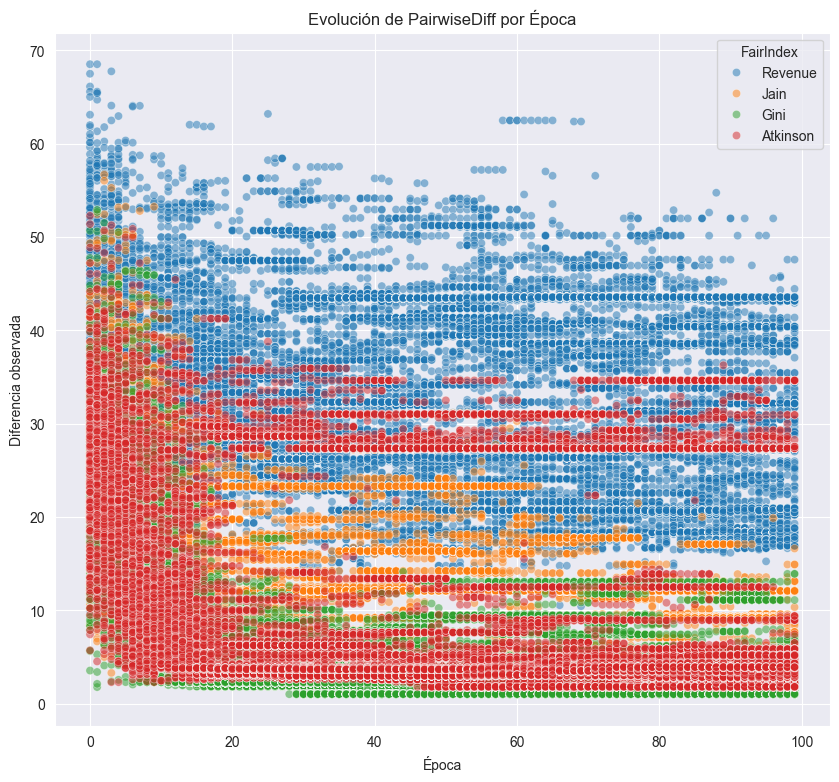

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 9))
sns.scatterplot(
    data=df_boxplot,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",  # O también "Run" según te interese
    alpha=0.5
)
plt.title("Evolución de PairwiseDiff por Época")
plt.xlabel("Época")
plt.ylabel("Diferencia observada")
plt.show()


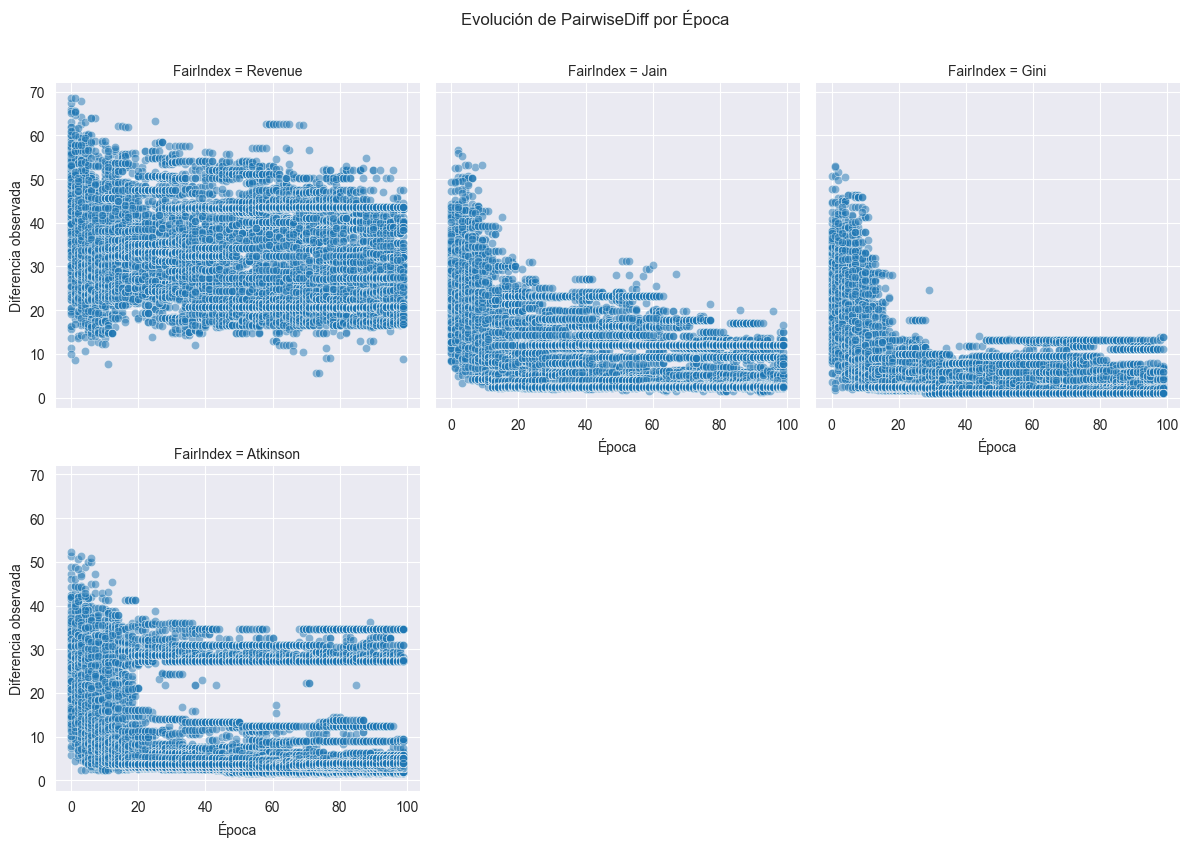

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creamos un FacetGrid: un subplot por cada valor único en 'FairIndex'
g = sns.FacetGrid(df_boxplot, col="FairIndex", col_wrap=3, height=4)
g.map(sns.scatterplot, "Iteration", "Fitness", alpha=0.5)

# Ajustamos etiquetas y título
g.set_axis_labels("Época", "Diferencia observada")
g.fig.suptitle("Evolución de PairwiseDiff por Época", y=1.05)

plt.show()

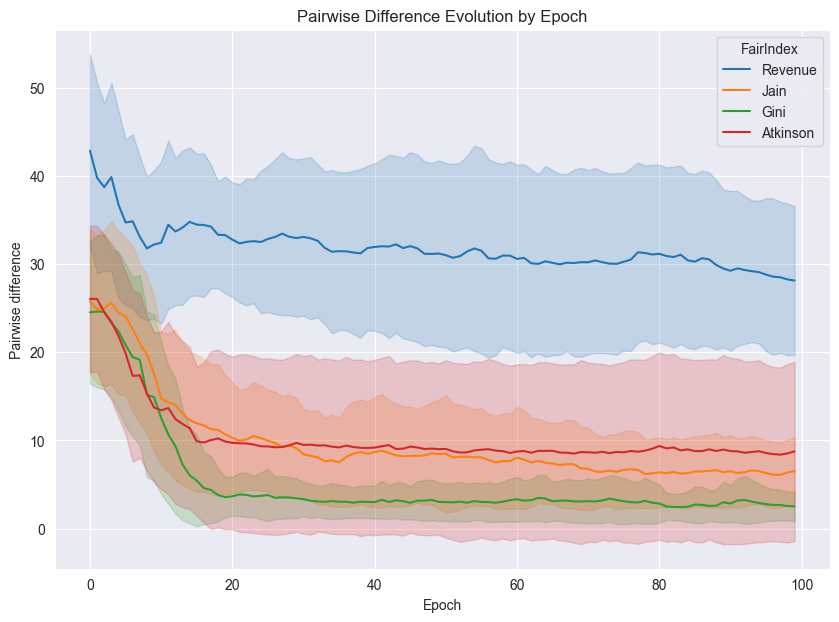

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.lineplot(
    data=df_boxplot,
    x="Iteration",
    y="Fitness",
    hue="FairIndex",
    estimator="mean",
    errorbar="sd",  # Standard deviation
    marker=None
)

plt.title("Pairwise Difference Evolution by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Pairwise difference")
plt.show()

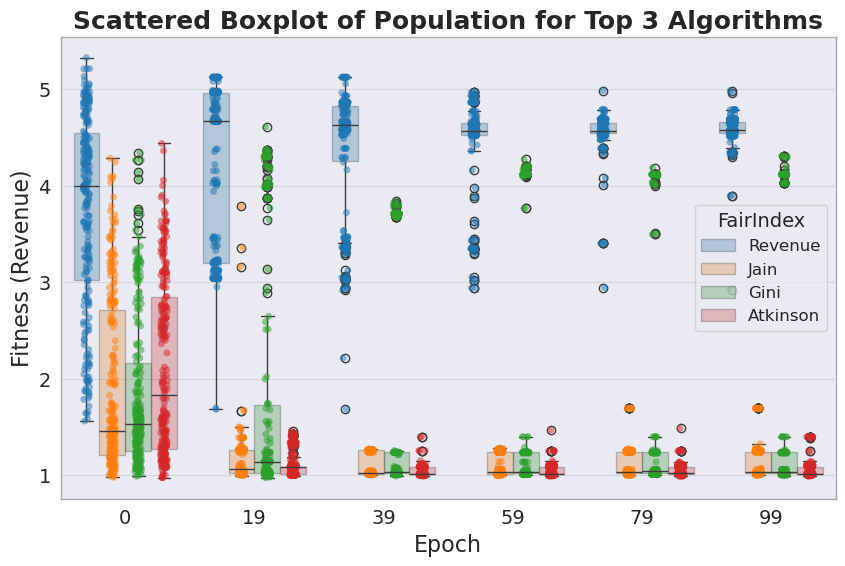

In [23]:
# Filter df, only rows with 'Iteration' values included in [0, .., 49]
df_boxplot_filtered = df_boxplot[df_boxplot['Iteration'].isin([0, 19, 39, 59, 79, 99])]

sns_box_plot(df=df_boxplot_filtered,
             x_data='Iteration',
             y_data='Fitness',
             hue='FairIndex',
             title="Scattered Boxplot of Population for Top 3 Algorithms",
             x_label="Epoch",
             y_label="Fitness (Revenue)",
             save_path=Path('../reports/mealpy/scattered_boxplot_top_3_25_equity.pdf'))

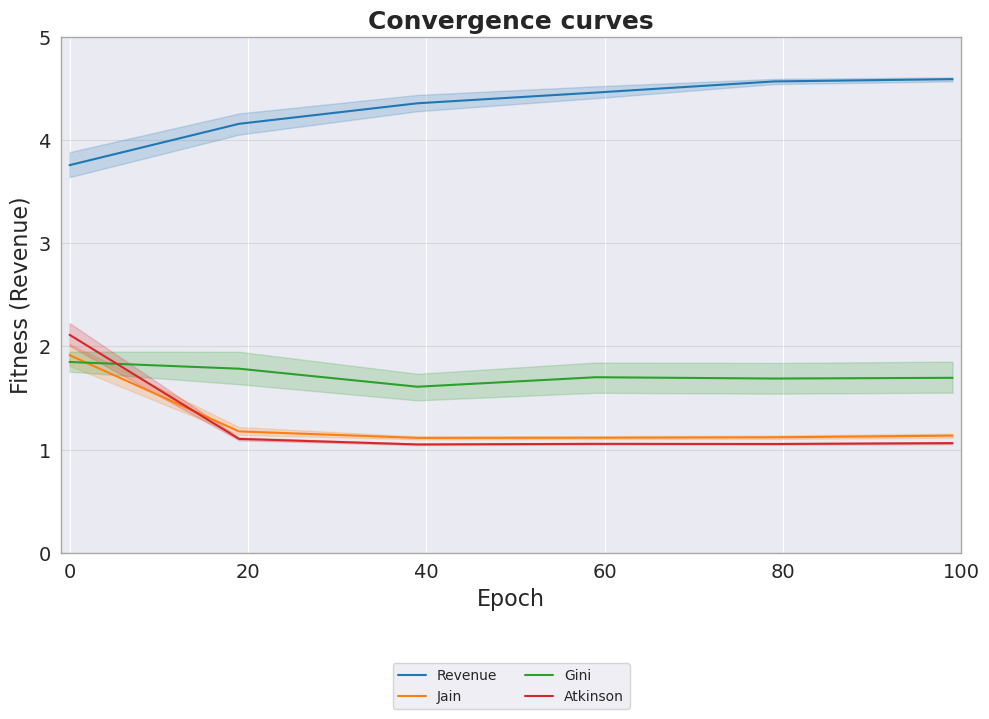

In [24]:
sns_line_plot(df=df_boxplot_filtered,
              x_data="Iteration",
              y_data="Fitness",
              hue="FairIndex",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(0,5),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity_pop.pdf'),
              fig_size=(10, 9))

In [16]:
columns_to_transform = df_history.filter(like="Real").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(float, x[1:-1].split())), dtype=np.int32))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2172.051246,0.875966,[False True False True False False False Tr...,"[1107, 1109, 1144, 1368, 1443, 1501, 1535, 159...",12.130909,0.000000,100.000000
1,1,Revenue,1,2393.917829,0.865383,[False True False False False False False Tr...,"[1107, 1109, 1147, 1396, 1443, 1501, 1535, 159...",11.349545,6.441097,93.558903
2,1,Revenue,2,2760.493201,0.887021,[False True True True False False False Tr...,"[1121, 1115, 1144, 1434, 1450, 1505, 1539, 159...",10.346515,14.709482,85.290518
3,1,Revenue,3,3079.196282,0.875909,[ True True False True False False False Tr...,"[1095, 1115, 1148, 1434, 1445, 1505, 1539, 159...",9.393939,22.561950,77.438050
4,1,Revenue,4,3410.657550,0.864926,[False True False True False False False Tr...,"[1078, 1113, 1144, 1434, 1441, 1500, 1535, 159...",8.071515,33.463229,66.536771


In [17]:
columns_to_transform = df_history.filter(like="Discrete").columns

df_history[columns_to_transform] = df_history[columns_to_transform].apply(
    lambda col: col.map(lambda x: np.array(list(map(lambda s: True if s == "True" else False, x[1:-1].split())), dtype=bool))
)

df_history.head()

,Run,FairIndex,Iteration,Fitness,ExecutionTime,Discrete,Real,Diversity,Exploitation,Exploration
0,1,Revenue,0,2172.051246,0.875966,"[False, True, False, True, False, False, False...","[1107, 1109, 1144, 1368, 1443, 1501, 1535, 159...",12.130909,0.000000,100.000000
1,1,Revenue,1,2393.917829,0.865383,"[False, True, False, False, False, False, Fals...","[1107, 1109, 1147, 1396, 1443, 1501, 1535, 159...",11.349545,6.441097,93.558903
2,1,Revenue,2,2760.493201,0.887021,"[False, True, True, True, False, False, False,...","[1121, 1115, 1144, 1434, 1450, 1505, 1539, 159...",10.346515,14.709482,85.290518
3,1,Revenue,3,3079.196282,0.875909,"[True, True, False, True, False, False, False,...","[1095, 1115, 1148, 1434, 1445, 1505, 1539, 159...",9.393939,22.561950,77.438050
4,1,Revenue,4,3410.657550,0.864926,"[False, True, False, True, False, False, False...","[1078, 1113, 1144, 1434, 1441, 1500, 1535, 159...",8.071515,33.463229,66.536771


In [24]:
import itertools

mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10,
    fair_index="Revenue",
    alpha=25
)

# Mapeo de servicios a nombres de RU (por ejemplo, "RU1", "RU2", etc.)
service_tsps = {service.id: service.tsp.name for service in supply.services}
ru_names = sorted(set(service_tsps.values()))

# Definir las columnas del nuevo DataFrame:
# FairIndex, Run, Revenue, Execution Time (s.), Scheduled Trains + una columna por cada RU
columns = ['FairIndex', 'Run', 'Fitness', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains'] + ru_names + ['Total Importance', 'Inequity', 'Assigned capacity']
summary_df = pd.DataFrame(columns=columns)

# Agrupar el historial por FairIndex y luego por Run
algo_grouped_df = df_history.groupby('FairIndex')

for algo_key, algo_group in algo_grouped_df:
    run_grouped_df = algo_group.groupby('Run')
    for run_label, run_group in run_grouped_df:
        run = run_group['Run'].iloc[-1]
        fitness = np.round(run_group['Fitness'].iloc[-1], 2)
        revenue = mptt.objective_function(run_group['Real'].iloc[-1])
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizamos la planificación (por si el método .sum_importance() depende de ello)
        mptt.update_schedule(real_solution)

        # Obtener el diccionario de importancias (por RU) a partir del vector booleano de servicios planificados.
        importance_dict = mptt.sum_importance(scheduled_trains_array)
        importance_dict = {f'RU{k}': v for k, v in importance_dict.items()}

        total_importance = sum(importance_dict.values())

        # Calcular la suma de diferencias absolutas pairwise entre las importancias.
        pairwise_diff = 0
        for ru1, ru2 in itertools.combinations(ru_names, 2):
            pairwise_diff += abs(importance_dict.get(ru1, 0) - importance_dict.get(ru2, 0))

        # Construir la fila de datos:
        row_data = [
            algo_key,
            run,
            fitness,
            revenue,
            execution_time,
            scheduled_trains
        ]

        # Agregar, para cada RU (ordenados alfabéticamente), el valor de suma de importancia.
        for ru in ru_names:
            # Si no existe valor para algún RU, se asigna 0
            row_data.append(round(importance_dict.get(ru, 0) * 100, 2))

        # Agregar la columna de Total Importance
        max_ineq = (len(ru_names)**2) / 4 if len(ru_names) % 2 == 0 else (len(ru_names) // 2) * ((len(ru_names) + 1) // 2)
        row_data.append(round(total_importance / len(ru_names) * 100, 2))
        # Agregar la columna de Pairwise Differences
        row_data.append(round(pairwise_diff / max_ineq * 100, 2))

        capacity_usage = 0.0
        for ru in ru_names:
            capacity_usage += importance_dict.get(ru, 0) * frame_capacity[ru]
        row_data.append(capacity_usage)

        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Pairwise Differences', ascending=True)
display(summary_df)
print()

,FairIndex,Run,Fitness,Revenue,Execution Time (s.),Scheduled Trains,RU1,RU2,RU3,RU4,RU5,Total Importance,Pairwise Differences,Assigned capacity
9,Gini,5,4470.74,3150.580214,86.95,23,48.75,47.68,48.76,48.75,47.85,48.36,1.02,48.404274
7,Gini,3,4215.82,3038.500859,87.77,24,47.98,47.68,47.91,46.13,47.67,47.48,1.32,47.568363
14,Jain,5,3233.95,1288.704190,87.58,23,47.06,47.68,46.74,46.13,47.67,47.05,1.34,47.055571
0,Atkinson,1,4563.35,3644.525183,87.98,24,48.04,48.95,48.70,50.11,47.85,48.73,1.81,48.701994
5,Gini,1,4282.09,3383.599289,86.73,23,49.42,47.68,48.76,50.11,49.15,49.02,1.84,48.951643
8,Gini,4,3774.26,2788.019121,86.88,23,49.74,48.14,48.85,50.63,47.85,49.04,2.39,49.131787
12,Jain,3,4093.99,2414.823043,86.56,26,49.76,45.83,49.29,48.75,49.33,48.59,2.81,48.519161
2,Atkinson,3,4542.72,3233.685313,89.04,23,49.60,50.22,51.30,50.88,47.67,49.93,2.85,50.097106
6,Gini,2,4616.41,3252.631047,87.64,24,50.90,52.06,51.30,50.88,47.67,50.56,3.07,50.931010
3,Atkinson,4,4040.56,3249.853199,88.93,24,48.75,47.68,49.52,44.32,47.85,47.62,3.82,47.847718


In [25]:
summary_df.to_latex()

'\\begin{tabular}{llrrrrrrrrrrrrr}\n\\toprule\n & FairIndex & Run & Fitness & Revenue & Execution Time (s.) & Scheduled Trains & RU1 & RU2 & RU3 & RU4 & RU5 & Total Importance & Pairwise Differences & Assigned capacity \\\\\n\\midrule\n9 & Gini & 5 & 4470.740000 & 3150.580214 & 86.950000 & 23 & 48.750000 & 47.680000 & 48.760000 & 48.750000 & 47.850000 & 48.360000 & 1.020000 & 48.404274 \\\\\n7 & Gini & 3 & 4215.820000 & 3038.500859 & 87.770000 & 24 & 47.980000 & 47.680000 & 47.910000 & 46.130000 & 47.670000 & 47.480000 & 1.320000 & 47.568363 \\\\\n14 & Jain & 5 & 3233.950000 & 1288.704190 & 87.580000 & 23 & 47.060000 & 47.680000 & 46.740000 & 46.130000 & 47.670000 & 47.050000 & 1.340000 & 47.055571 \\\\\n0 & Atkinson & 1 & 4563.350000 & 3644.525183 & 87.980000 & 24 & 48.040000 & 48.950000 & 48.700000 & 50.110000 & 47.850000 & 48.730000 & 1.810000 & 48.701994 \\\\\n5 & Gini & 1 & 4282.090000 & 3383.599289 & 86.730000 & 23 & 49.420000 & 47.680000 & 48.760000 & 50.110000 & 49.150000 & 49.

In [26]:
# Table with results by run

mptt = MPTT(requested_schedule=requested_schedule,
                revenue_behavior=revenue_behavior,
                line=line,
                safe_headway=10,
                fair_index="Revenue")

service_tsps = {service.id: service.tsp.name for service in supply.services}
columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)', 'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)']
columns += sorted(set(service_tsps.values()))
columns += [f"{tsp}_equity" for tsp in sorted(set(service_tsps.values()))]
summary_df = pd.DataFrame(columns=columns)

algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for group in run_grouped_df.groups:
        run = run_grouped_df.get_group(group)['Run'].iloc[-1]
        revenue = np.round(run_grouped_df.get_group(group)['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_grouped_df.get_group(group)['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_grouped_df.get_group(group)['Discrete'].iloc[-1]
        scheduled_trains = int(sum(run_grouped_df.get_group(group)['Discrete'].iloc[-1]))
        real_solution = run_grouped_df.get_group(group)['Real'].iloc[-1]
        mptt.update_schedule(real_solution)
        delta_dt = 0.0
        delta_tt = 0.0
        services_by_tsp = {tsp: 0 for tsp in sorted(service_tsps.values())}
        for i, service in enumerate(mptt.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            departure_station = list(mptt.requested_schedule[service].keys())[0]
            delta_dt += abs(mptt.updated_schedule[service][departure_station][1] -
                            mptt.requested_schedule[service][departure_station][1])
            for j, stop in enumerate(mptt.requested_schedule[service].keys()):
                if j == 0 or j == len(mptt.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(mptt.updated_schedule[service][stop][1] - mptt.requested_schedule[service][stop][1])
    
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1
    
        percentages_by_tsp = {}
        for tsp in services_by_tsp:
            percentages_by_tsp[tsp] = f"{np.round(services_by_tsp[tsp] / tsp_df.loc[tsp, 'Number of Services'] * 100, 2)} %"

        frame_capacity_dict = {}
        for tsp in services_by_tsp:
            frame_capacity_dict[f"{tsp}_equity"] = f"{np.round(services_by_tsp[tsp] / 25 * 100, 2)}"

        row_data =  [algo_group[0],
                     run,
                     revenue,
                     execution_time,
                     scheduled_trains,
                     np.round(delta_dt, 2),
                     np.round(delta_tt, 2),
                     *list(percentages_by_tsp.values()),
                     *list(frame_capacity_dict.values())]
        summary_df.loc[len(summary_df)] = row_data

summary_df = summary_df.sort_values('Revenue', ascending=False)
display(summary_df)
print()

,FairIndex,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),RU1,RU2,RU3,RU4,RU5,RU1_equity,RU2_equity,RU3_equity,RU4_equity,RU5_equity
16,Revenue,2,7258.89,85.54,27,322.0,207.0,53.33 %,58.33 %,50.0 %,50.0 %,60.0 %,32.0,28.0,20.0,16.0,12.0
15,Revenue,1,7244.70,86.29,29,547.0,215.0,73.33 %,58.33 %,30.0 %,62.5 %,60.0 %,44.0,28.0,12.0,20.0,12.0
19,Revenue,5,7210.23,85.80,29,293.0,179.0,60.0 %,58.33 %,60.0 %,50.0 %,60.0 %,36.0,28.0,24.0,16.0,12.0
18,Revenue,4,6625.12,84.74,27,314.0,199.0,40.0 %,58.33 %,60.0 %,50.0 %,80.0 %,24.0,28.0,24.0,16.0,16.0
17,Revenue,3,6356.56,86.17,27,475.0,143.0,46.67 %,66.67 %,50.0 %,50.0 %,60.0 %,28.0,32.0,20.0,16.0,12.0
4,Atkinson,5,4740.04,87.69,27,241.0,132.0,46.67 %,58.33 %,70.0 %,37.5 %,60.0 %,28.0,28.0,28.0,12.0,12.0
6,Gini,2,4616.41,87.64,24,328.0,119.0,53.33 %,58.33 %,40.0 %,37.5 %,40.0 %,32.0,28.0,16.0,12.0,8.0
0,Atkinson,1,4563.35,87.98,24,411.0,139.0,40.0 %,50.0 %,60.0 %,37.5 %,60.0 %,24.0,24.0,24.0,12.0,12.0
2,Atkinson,3,4542.72,89.04,23,273.0,140.0,53.33 %,50.0 %,40.0 %,37.5 %,40.0 %,32.0,24.0,16.0,12.0,8.0
9,Gini,5,4470.74,86.95,23,210.0,83.0,33.33 %,58.33 %,50.0 %,37.5 %,60.0 %,20.0,28.0,20.0,12.0,12.0


In [ ]:
frame_capacity

In [27]:
# Supongamos que frame_capacity_target es un diccionario como:

sm = RevenueMaximization(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=10
)

# Diccionario para relacionar cada servicio con el nombre de su RU.
service_tsps = {service.id: service.tsp.name for service in supply.services}

# Definir las columnas del dataframe de resumen.
base_columns = ['FairIndex', 'Run', 'Revenue', 'Execution Time (s.)',
                'Scheduled Trains', 'Delta DT (min.)', 'Delta TT (min.)', 'Overall Fairness']
# Ordenamos alfabéticamente los nombres de RU
ru_names = sorted(set(service_tsps.values()))
# Se añaden columnas con el porcentaje alcanzado (a nivel de RU) y
# columnas informativas con el nombre _equity para cada RU.
summary_columns = base_columns + ru_names + [f"{tsp}_equity" for tsp in ru_names]
summary_df = pd.DataFrame(columns=summary_columns)

# Agrupamos df_history por FairIndex (cada grupo corresponde a un método/algoritmo)
algo_grouped_df = df_history.groupby('FairIndex')

for algo_group in algo_grouped_df:
    run_grouped_df = algo_group[1].groupby('Run')
    for run_label, run_group in run_grouped_df:
        # Extraer valores de la ejecución
        run = run_group['Run'].iloc[-1]
        revenue = np.round(run_group['Fitness'].iloc[-1], 2)
        execution_time = np.round(run_group['ExecutionTime'].sum(), 2)
        scheduled_trains_array = run_group['Discrete'].iloc[-1]
        scheduled_trains = int(sum(scheduled_trains_array))
        real_solution = run_group['Real'].iloc[-1]

        # Actualizar la planificación con la solución real (se ignoran los servicios no programados)
        sm.update_schedule(Solution(real=real_solution, discrete=scheduled_trains_array))
        delta_dt = 0.0
        delta_tt = 0.0

        # Inicializar contadores para cada RU (por ejemplo, 'RU1', 'RU2', etc.)
        services_by_tsp = {tsp: 0 for tsp in ru_names}

        # Para cada servicio del plan solicitado, si está programado se acumulan los deltas y se cuenta la RU
        for i, service in enumerate(sm.requested_schedule):
            if not scheduled_trains_array[i]:
                continue
            # Para el primer stop se calcula el delta en DT
            departure_station = list(sm.requested_schedule[service].keys())[0]
            delta_dt += abs(
                sm.updated_schedule[service][departure_station][1] -
                sm.requested_schedule[service][departure_station][1]
            )
            # Para los stops intermedios se acumulan los deltas en TT
            for j, stop in enumerate(sm.requested_schedule[service].keys()):
                if j == 0 or j == len(sm.requested_schedule[service]) - 1:
                    continue
                delta_tt += abs(
                    sm.updated_schedule[service][stop][1] -
                    sm.requested_schedule[service][stop][1]
                )
            # Incrementar contador según el RU del servicio
            service_tsp = service_tsps[service]
            services_by_tsp[service_tsp] += 1

        # Calcular el porcentaje alcanzado para cada RU comparando con su capacidad marco.
        # Por ejemplo, si para 'RU1' se programaron 15 servicios y la capacidad marco es 30, se alcanza el 50%.
        percentages_by_tsp = {}
        ru_equity = {}  # Almacenará el valor numérico (por ejemplo, 50.0) para cada RU
        for tsp in ru_names:
            target = services_by_ru[tsp]  # capacidad marco del RU
            achieved = services_by_tsp[tsp]
            percentage = np.round(achieved / target * 100, 2) if target != 0 else 0.0
            percentages_by_tsp[tsp] = f"{percentage} %"
            ru_equity[tsp] = percentage

        # Calcular el índice de equidad global (Overall Fairness) usando la fórmula de Jain:
        # J = (sum(r_i)^2) / (n * sum(r_i^2))
        r_values = list(ru_equity.values())
        n = len(r_values)
        sum_r = sum(r_values)
        sum_r_sq = sum([r**2 for r in r_values])
        overall_fairness = (sum_r**2) / (n * sum_r_sq) if sum_r_sq != 0 else 0

        # Preparar la fila de datos. Se agregan:
        # - Las métricas generales
        # - Para cada RU, el porcentaje alcanzado (según el orden en ru_names)
        # - Para cada RU, se incluye una columna con el nombre <RU>_equity que muestra el mismo valor numérico
        row_data = [
            algo_group[0],            # FairIndex (método)
            run,
            revenue,
            execution_time,
            scheduled_trains,
            np.round(delta_dt, 2),
            np.round(delta_tt, 2),
            np.round(overall_fairness, 4)  # Se puede multiplicar por 100 si se prefiere porcentaje
        ]
        # Agregar los porcentajes por RU
        for tsp in ru_names:
            row_data.append(percentages_by_tsp[tsp])
        # Agregar las columnas de _equity (se puede mostrar el valor numérico)
        for tsp in ru_names:
            row_data.append(ru_equity[tsp])

        # Añadir la fila al dataframe resumen
        summary_df.loc[len(summary_df)] = row_data

# Ordenar el dataframe de salida según el Overall Fairness de forma descendente
summary_df = summary_df.sort_values('Overall Fairness', ascending=False)
display(summary_df)
print()


,FairIndex,Run,Revenue,Execution Time (s.),Scheduled Trains,Delta DT (min.),Delta TT (min.),Overall Fairness,RU1,RU2,RU3,RU4,RU5,RU1_equity,RU2_equity,RU3_equity,RU4_equity,RU5_equity
19,Revenue,5,7210.23,85.80,29,293.0,179.0,0.9955,60.0 %,58.33 %,60.0 %,50.0 %,60.0 %,60.00,58.33,60.0,50.0,60.0
16,Revenue,2,7258.89,85.54,27,322.0,207.0,0.9942,53.33 %,58.33 %,50.0 %,50.0 %,60.0 %,53.33,58.33,50.0,50.0,60.0
10,Jain,1,3681.35,86.65,25,462.0,104.0,0.9923,46.67 %,50.0 %,50.0 %,50.0 %,60.0 %,46.67,50.00,50.0,50.0,60.0
13,Jain,4,2541.88,86.62,22,163.0,30.0,0.9890,40.0 %,41.67 %,50.0 %,50.0 %,40.0 %,40.00,41.67,50.0,50.0,40.0
1,Atkinson,2,3131.21,88.78,26,351.0,65.0,0.9818,53.33 %,58.33 %,40.0 %,50.0 %,60.0 %,53.33,58.33,40.0,50.0,60.0
17,Revenue,3,6356.56,86.17,27,475.0,143.0,0.9816,46.67 %,66.67 %,50.0 %,50.0 %,60.0 %,46.67,66.67,50.0,50.0,60.0
2,Atkinson,3,4542.72,89.04,23,273.0,140.0,0.9802,53.33 %,50.0 %,40.0 %,37.5 %,40.0 %,53.33,50.00,40.0,37.5,40.0
7,Gini,3,4215.82,87.77,24,283.0,89.0,0.9791,40.0 %,58.33 %,50.0 %,50.0 %,40.0 %,40.00,58.33,50.0,50.0,40.0
8,Gini,4,3774.26,86.88,23,359.0,83.0,0.9786,40.0 %,41.67 %,50.0 %,50.0 %,60.0 %,40.00,41.67,50.0,50.0,60.0
12,Jain,3,4093.99,86.56,26,394.0,142.0,0.9753,53.33 %,50.0 %,60.0 %,37.5 %,60.0 %,53.33,50.00,60.0,37.5,60.0


In [ ]:
summary_df.to_latex()

In [28]:
# Global status

def get_global_status(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')

    for algo_group in algo_grouped_df:
        run_grouped_df = algo_group[1].groupby('Run')
        
        print(f"Global {algo_group[0]} status:")
        
        # Execution time (mean and std.)
        run_times = run_grouped_df['ExecutionTime'].last()
        print(f'\tTotal execution time: {round(run_times.sum(), 4)} s.')
        print(f'\tExecution Time (by run) - Mean: {round(run_times.mean(), 4)} s. - Std: {round(run_times.std(), 4)} s.')
        
        # Revenue (mean and std.)
        run_revenues = run_grouped_df['Fitness'].last()
        print(f'\tRevenue - Mean: {round(run_revenues.mean(), 4)} - Std: {round(run_revenues.std(), 4)}')
        
        # Scheduled trains (mean and std.)
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        print(f'\tScheduled Trains - Mean: {np.round(run_trains.mean())} - Std: {np.round(run_trains.std())}')
        
        max_revenue = sum([sm.revenue[service]['canon'] for service in sm.revenue])
        print(f"\tMax Revenue: {max_revenue} - WARNING!: Scheduling all services could not be feasible")
        print()
        
get_global_status(df_history)

Global Atkinson status:
	Total execution time: 4.4666 s.
	Execution Time (by run) - Mean: 0.8933 s. - Std: 0.012 s.
	Revenue - Mean: 4203.5782 - Std: 653.6023
	Scheduled Trains - Mean: 25.0 - Std: 2.0
	Max Revenue: 12045.0 - WARNING!: Scheduling all services could not be feasible

Global Gini status:
	Total execution time: 4.3578 s.
	Execution Time (by run) - Mean: 0.8716 s. - Std: 0.0077 s.
	Revenue - Mean: 4271.8651 - Std: 319.8112
	Scheduled Trains - Mean: 23.0 - Std: 1.0
	Max Revenue: 12045.0 - WARNING!: Scheduling all services could not be feasible

Global Jain status:
	Total execution time: 4.3943 s.
	Execution Time (by run) - Mean: 0.8789 s. - Std: 0.0125 s.
	Revenue - Mean: 3394.184 - Std: 575.5319
	Scheduled Trains - Mean: 25.0 - Std: 2.0
	Max Revenue: 12045.0 - WARNING!: Scheduling all services could not be feasible

Global Revenue status:
	Total execution time: 4.3004 s.
	Execution Time (by run) - Mean: 0.8601 s. - Std: 0.0256 s.
	Revenue - Mean: 6939.1019 - Std: 420.4492
	S

In [29]:

def get_global_status_as_dataframe(df: pd.DataFrame):
    algo_grouped_df = df.groupby('FairIndex')
    
    results = []
    for algo_name, algo_group in algo_grouped_df:
        run_grouped_df = algo_group.groupby('Run')
        
        run_times = run_grouped_df['ExecutionTime'].sum()
        
        run_revenues = run_grouped_df['Fitness'].last()
        run_trains = run_grouped_df['Discrete'].last().apply(sum)
        
        result = {
            'FairIndex': algo_name,
            'Mean Execution Time (seconds)': round(run_times.mean(), 2),
            'Std Execution Time (seconds)': round(run_times.std(), 2),
            'Mean Fitness (revenue)': round(run_revenues.mean(), 2),
            'Std Fitness (revenue)': round(run_revenues.std(), 2),
            'Mean Scheduled Trains': int(round(run_trains.mean())),
            'Std Scheduled Trains': int(round(run_trains.std()))
        }
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    # Short by column 'Mean Fitness' 
    results_df = results_df.sort_values(by='Mean Fitness (revenue)', ascending=False).reset_index(drop=True)
    return results_df

results_df = get_global_status_as_dataframe(df_history)
results_df

,FairIndex,Mean Execution Time (seconds),Std Execution Time (seconds),Mean Fitness (revenue),Std Fitness (revenue),Mean Scheduled Trains,Std Scheduled Trains
0,Revenue,85.71,0.62,6939.10,420.45,28,1
1,Gini,87.19,0.48,4271.87,319.81,23,1
2,Atkinson,88.49,0.61,4203.58,653.60,25,2
3,Jain,87.18,0.84,3394.18,575.53,25,2


In [30]:
results_df.to_latex()

'\\begin{tabular}{llrrrrrr}\n\\toprule\n & FairIndex & Mean Execution Time (seconds) & Std Execution Time (seconds) & Mean Fitness (revenue) & Std Fitness (revenue) & Mean Scheduled Trains & Std Scheduled Trains \\\\\n\\midrule\n0 & Revenue & 85.710000 & 0.620000 & 6939.100000 & 420.450000 & 28 & 1 \\\\\n1 & Gini & 87.190000 & 0.480000 & 4271.870000 & 319.810000 & 23 & 1 \\\\\n2 & Atkinson & 88.490000 & 0.610000 & 4203.580000 & 653.600000 & 25 & 2 \\\\\n3 & Jain & 87.180000 & 0.840000 & 3394.180000 & 575.530000 & 25 & 2 \\\\\n\\bottomrule\n\\end{tabular}\n'

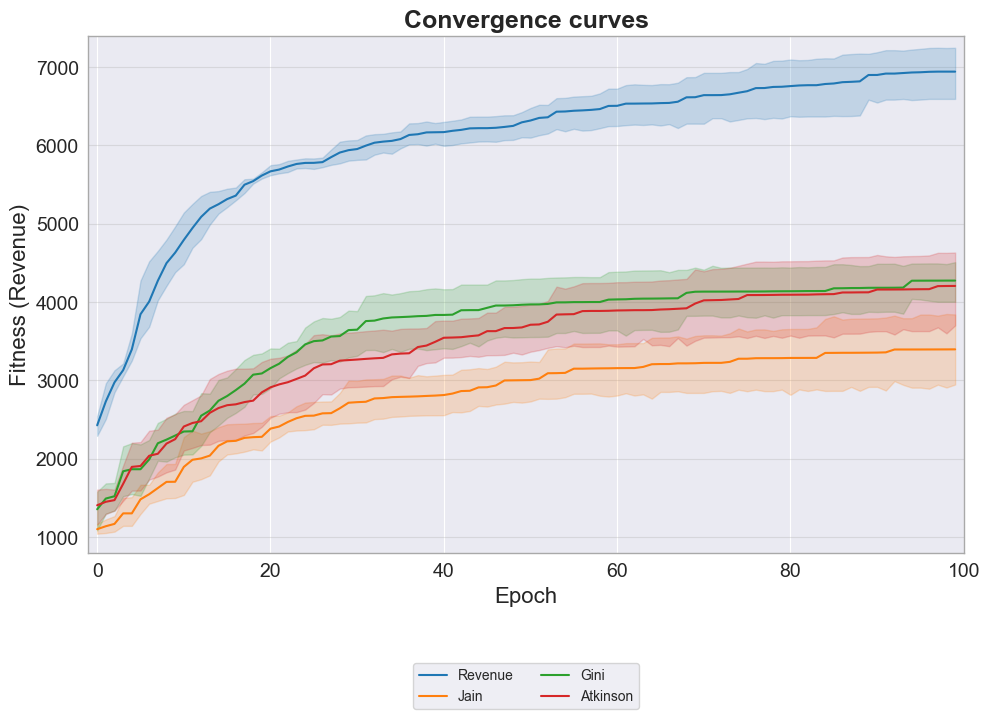

In [35]:
sns_line_plot(df=df_history,
              x_data="Iteration",
              y_data="Fitness",
              hue="FairIndex",
              title="Convergence curves",
              x_label="Epoch",
              y_label="Fitness (Revenue)",
              x_limit=(-1, 100),
              y_limit=(800,7400),
              save_path=Path('../reports/mealpy/mealpy_convergence_equity_semi.pdf'),
              fig_size=(10, 9))

In [ ]:
df_history.head()

In [ ]:
N = 50  # Número de saltos que quieres aplicar

algo_1_vals = df_history[df_history['Algo'] == 'Simulated Annealing'] \
    .groupby(['Run', 'Iteration'])['Fitness'].last() \
    .groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()

algo_1_vals

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Genetic Algorithm']

algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
algo_df = df_history[df_history['Algo'] == 'Simulated Annealing']

N = 50
algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()

algo_vals

In [ ]:
print(len(algo_vals))

In [ ]:
# Confusion Matrix stadistical differences 

from scipy import stats

def get_epoch_last_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(list).sum()
    else:
        algo_vals = algo_df.groupby(['Run', 'Iteration'])['Fitness'].last().groupby(level='Run').apply(lambda x: x.iloc[::N].tolist()).sum()
    return algo_vals

def get_epoch_best_fitness(df, name):
    algo_df = df[df['Algo'] == name]
    if name != 'Simulated Annealing':
        algo_vals = algo_df.groupby(['Iteration'])['Fitness'].max().tolist()
    else:
        algo_vals = algo_df.groupby(algo_df['Iteration'] // N)['Fitness'].max().tolist()
    return algo_vals

matrix_wilcoxon = []
matrix_p_values = []
for algo_name, algo in mp_algos.items():
    row_w = []
    row_p = []
    for algo_name_2, algo_2 in mp_algos.items():
        if algo_name == algo_name_2:
            row_w.append(np.nan)
            row_p.append(np.nan)
            continue
        
        algo_1_vals = get_epoch_best_fitness(df_history, algo_name)
        algo_2_vals = get_epoch_best_fitness(df_history, algo_name_2)
        stat, p_value = stats.wilcoxon(algo_1_vals, algo_2_vals)
        row_w.append(round(stat))
        row_p.append(round(p_value, 3))
    matrix_wilcoxon.append(row_w)
    matrix_p_values.append(row_p)

In [ ]:
print("Wilcoxon Matrix")
df_wilcoxon = pd.DataFrame(matrix_wilcoxon, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_wilcoxon)

In [ ]:
print("P-Values Matrix")
df_p_values = pd.DataFrame(matrix_p_values, index=mp_algos.keys(), columns=mp_algos.keys())
print(df_p_values)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_wilcoxon, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_wilcoxon.columns, rotation=30, ha='right')
plt.yticks(range(10), df_wilcoxon.index)
plt.title('Confusion Matrix - Wilcoxon Statistic', fontweight='bold', fontsize=18)

for i in range(df_wilcoxon.shape[0]):
    for j in range(df_wilcoxon.shape[1]):
        value = df_wilcoxon.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{int(value)}"
            text_color = 'black' if value > 50000 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/wilcoxon_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
# Visualización con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(df_p_values, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Statistical difference')
plt.xticks(range(10), df_p_values.columns, rotation=30, ha='right')
plt.yticks(range(10), df_p_values.index)
plt.title('Confusion Matrix - P-values', fontweight='bold', fontsize=18)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            # Manejo especial para NaN
            display_value = "NaN"
            text_color = 'white'  # Color negro para NaN
            rect_color = (0.2, 0.2, 0.2)  # Gris oscuro
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.4 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color)
        
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_5_seed.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(12, 10))
plt.imshow(df_p_values, cmap='seismic', interpolation='nearest')
plt.colorbar(label='P-value', shrink=0.8)
plt.xticks(range(df_p_values.shape[1]), df_p_values.columns, rotation=45, ha='right', fontsize=10)
plt.yticks(range(df_p_values.shape[0]), df_p_values.index, fontsize=10)
plt.title('Matrix of P-values Between Algorithms', fontweight='bold', fontsize=20)

for i in range(df_p_values.shape[0]):
    for j in range(df_p_values.shape[1]):
        value = df_p_values.iloc[i, j]
        if np.isnan(value):
            display_value = "NaN"
            text_color = 'white'
            rect_color = (0.5, 0.5, 0.5)
            plt.gca().add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=rect_color))
        else:
            display_value = f"{value:.3f}"
            text_color = 'black' if value > 0.3 and value < 0.7 else 'white'
        
        plt.text(j, i, display_value, ha='center', va='center', color=text_color, fontsize=8)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, df_p_values.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, df_p_values.shape[0], 1), minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig("../figures/p_values_confusion_matrix_improved.pdf", format='pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
stat, p_value = stats.wilcoxon(genetic_revenues_mean, acor_revenues_mean)
print(f"Estadístico de Wilcoxon: {stat}, Valor p: {p_value}")

In [ ]:
# Select a solution from df_history:
algo_name = 'Genetic Algorithm'
run = 1
iteration = 99

filtered_row = df_history[
    (df_history["Algo"] == algo_name) &
    (df_history["Run"] == run) &
    (df_history["Iteration"] == iteration)
]

# Get values from columns "Real" & "Discrete"
if not filtered_row.empty:
    real_value = filtered_row["Real"].iloc[0]
    discrete_value = filtered_row["Discrete"].iloc[0]
    ga_best_sol = Solution(real=real_value, discrete=discrete_value)
    print(f"Real: {real_value}, Discrete: {discrete_value}")
else:
    print("Row not found matching the provided parameters.")

In [ ]:
sm = RevenueMaximization(requested_schedule=requested_schedule,
                         revenue_behavior=revenue_behavior,
                         line=line,
                         safe_headway=10)

services = sm.update_supply(path=generator_save_path,
                            solution=ga_best_sol)

sm.update_schedule(solution=ga_best_sol)

filtered_services = {}
for i, service in enumerate(sm.updated_schedule):
    if ga_best_sol.discrete[i]:
        filtered_services[service] = sm.updated_schedule[service]

#plotter = TrainSchedulePlotter(filtered_services, line)
#plotter.plot(plot_security_gaps=True, save_path=Path('../figures/updated.pdf'))

tt_file_name = f'{supply_config_path.stem}_gsa'
print(supply_save_path, tt_file_name)
SupplySaver(services).to_yaml(filename=f'{tt_file_name}.yml', save_path=supply_save_path)

# Copy previous file in reports
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_25_new.yml')

supply_config_file = Path(f'{supply_save_path}{tt_file_name}.yml')

In [ ]:
final_supply = Supply.from_yaml(supply_config_file)

In [ ]:
plot_marey_chart(requested_supply=final_supply,
                 colors_by_tsp=True, 
                 main_title="Diagrama de Marey",
                 plot_security_gaps=True,
                 security_gap=10,
                 save_path=Path('../reports/mealpy/marey_chart_ga_25.pdf'))

In [ ]:
shutil.copyfile(f"{supply_save_path}{tt_file_name}.yml", reports_path / f'{tt_file_name}_equity.yml')

In [ ]:
#!snakeviz profile.pstat